In [ ]:
!pip install kaggle
!pip install albumentations==0.4.6

In [ ]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l

total 20
drwxr-xr-x   3 root root 4096 Nov 20 03:25 '{'
drwx------   5 root root 4096 Nov 20 03:24  drive
drwxr-xr-x 112 root root 4096 Nov 20 03:29  kaggle_3m
drwxr-xr-x   3 root root 4096 Nov 20 03:25  lgg-mri-segmentation
drwxr-xr-x   1 root root 4096 Nov 18 14:36  sample_data


In [ ]:
token={"username":"akkinasrikar","key":"c9db8d26c294fb5f8c9b64f4ad32684a"}

In [ ]:
import json
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from IPython.display import clear_output 

In [ ]:
!unzip "/content/{/content}/datasets/mateuszbuda/lgg-mri-segmentation/lgg-mri-segmentation.zip"
clear_output()

In [ ]:
import sys
import os
import glob
import cv2
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from mpl_toolkits.axes_grid import ImageGrid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
plt.style.use("dark_background")

In [ ]:
#Data Path
data_path="/content/lgg-mri-segmentation/kaggle_3m/"
#os.listdir(data_path)

In [ ]:
BASE_LEN = len("/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_")
END_IMG_LEN = 4 
END_MASK_LEN = 9 
IMG_SIZE = 512

In [ ]:
data_map=[]
for sub_dir_path in glob.glob(data_path+"*"):
  if os.path.isdir(sub_dir_path):
    dirname=sub_dir_path.split("/")[-1]
    for filename in os.listdir(sub_dir_path):
      image_path=sub_dir_path+"/"+filename
      data_map.extend([dirname,image_path])
  else:
    print("This is not a directory ",sub_dir_path)

This is not a directory  /content/lgg-mri-segmentation/kaggle_3m/README.md
This is not a directory  /content/lgg-mri-segmentation/kaggle_3m/data.csv


In [ ]:
data_map[:5]

['TCGA_HT_7605_19950916',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_13_mask.tif',
 'TCGA_HT_7605_19950916',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_8_mask.tif',
 'TCGA_HT_7605_19950916']

In [ ]:
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

,dirname,path
0,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
1,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
2,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
3,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
4,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...


In [ ]:
df_imgs=df[~df["path"].str.contains("mask")]
df_masks=df[df["path"].str.contains("mask")]

In [ ]:
len(df_imgs),len(df_masks)

(3929, 3929)

In [ ]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [ ]:
idx=np.random.randint(0,len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46.tif 
Path to the Mask: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46_mask.tif


In [ ]:
final_data=pd.DataFrame({"Patient":df_imgs.dirname.values,
                         "image_path":imgs,
                         "mask_path":masks})

In [ ]:
final_data.head()

,Patient,image_path,mask_path
0,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
1,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
4,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...


In [ ]:
def positive_negative_diagnosis(mpath):
  value=np.max(cv2.imread(mpath))
  if value>0:return 1
  return 0

In [ ]:
final_data["diagnosis"]=final_data["mask_path"].apply(lambda m : positive_negative_diagnosis(m))

In [ ]:
final_data.head()

,Patient,image_path,mask_path,diagnosis
0,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
1,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
3,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
4,TCGA_HT_7605_19950916,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0


In [ ]:
final_data["diagnosis"].value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [ ]:
final_data["diagnosis"][3800]

0

ID - 1626  Label - 0


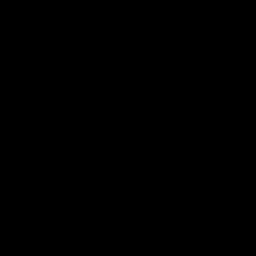

In [ ]:
#negative-1 diagnosis mask
n=np.random.randint(3500)
print("ID -",n," Label -",final_data.diagnosis[n])
cv2_imshow(cv2.imread(final_data["mask_path"][n]))

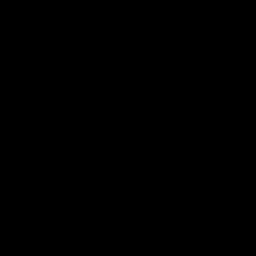

In [ ]:

#positive-0 diagnosis mask
cv2_imshow(cv2.imread(final_data["mask_path"][1800]))

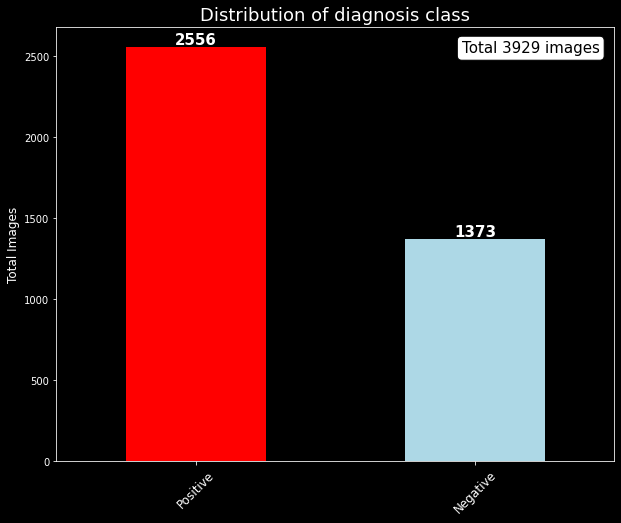

In [ ]:
plt.figure(figsize=(10,8))
bbox=dict(boxstyle="round",fc=("white"),ec=("black"),)
ax=final_data["diagnosis"].value_counts().plot(kind="bar",stacked="true", color=["red","lightblue"])
ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12)
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of diagnosis class",fontsize = 18, y=1)
ax.text(1.2, 2550, f"Total {len(final_data)} images", size=15,color="black",ha="center", va="center",bbox=bbox)
for i,rows in enumerate(final_data.diagnosis.value_counts().values):
  ax.annotate(int(rows),xy=(i, rows-3), 
              rotation=0, color="white", 
              ha="center", verticalalignment='bottom', 
              fontsize=15, fontweight="bold")
ax

In [ ]:
patients_by_diagnosis=final_data.groupby(["Patient","diagnosis"])["diagnosis"].size().unstack().fillna(0)
patients_by_diagnosis

diagnosis,0,1
Patient,,
TCGA_CS_4941_19960909,12.0,11.0
TCGA_CS_4942_19970222,9.0,11.0
TCGA_CS_4943_20000902,8.0,12.0
TCGA_CS_4944_20010208,14.0,6.0
TCGA_CS_5393_19990606,5.0,15.0
...,...,...
TCGA_HT_8563_19981209,23.0,0.0
TCGA_HT_A5RC_19990831,15.0,17.0
TCGA_HT_A616_19991226,28.0,0.0


In [ ]:
patients_by_diagnosis.columns=["Positive","Negative"]

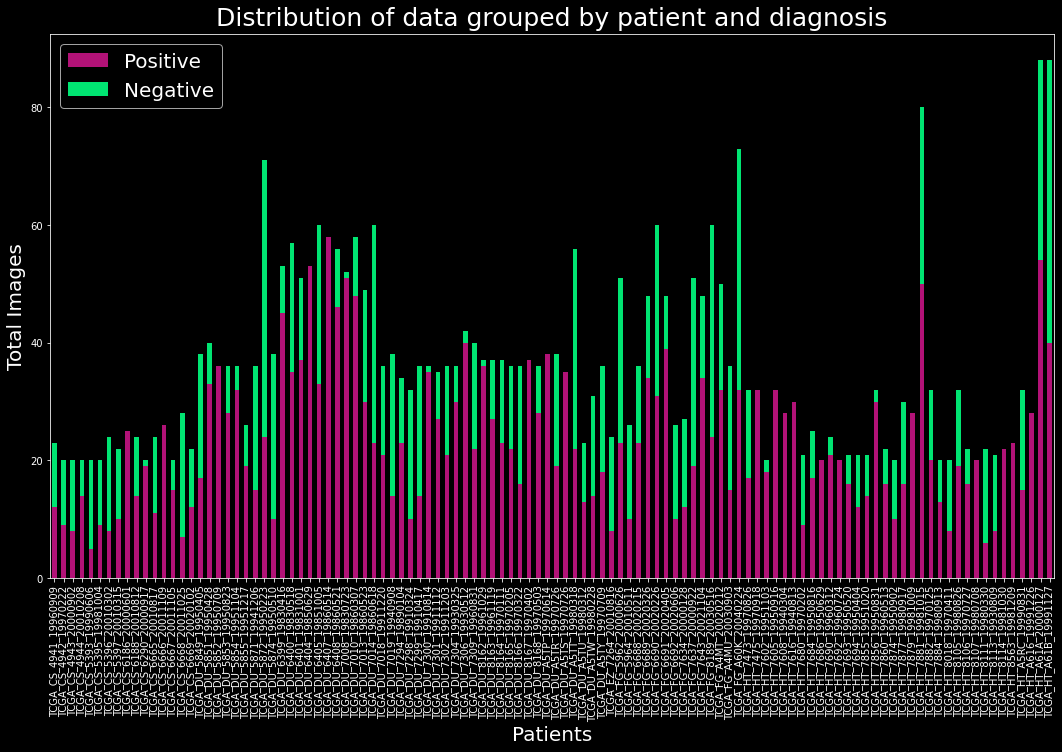

In [ ]:
ax=patients_by_diagnosis.plot(kind="bar",stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)
ax

In [ ]:
sample_yes_imgs=final_data[final_data["diagnosis"]==1].sample(5).image_path.values
sample_no_imgs=final_data[final_data["diagnosis"]==0].sample(5).image_path.values
sample_yes_imgs

array(['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_44.tif',
       '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_21.tif',
       '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_28.tif',
       '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_44.tif',
       '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_20.tif'],
      dtype=object)

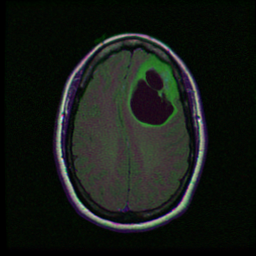

In [ ]:
cv2_imshow(cv2.imread(sample_yes_imgs[0]))

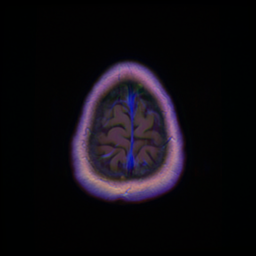

In [ ]:
cv2_imshow(cv2.imread(sample_no_imgs[1]))

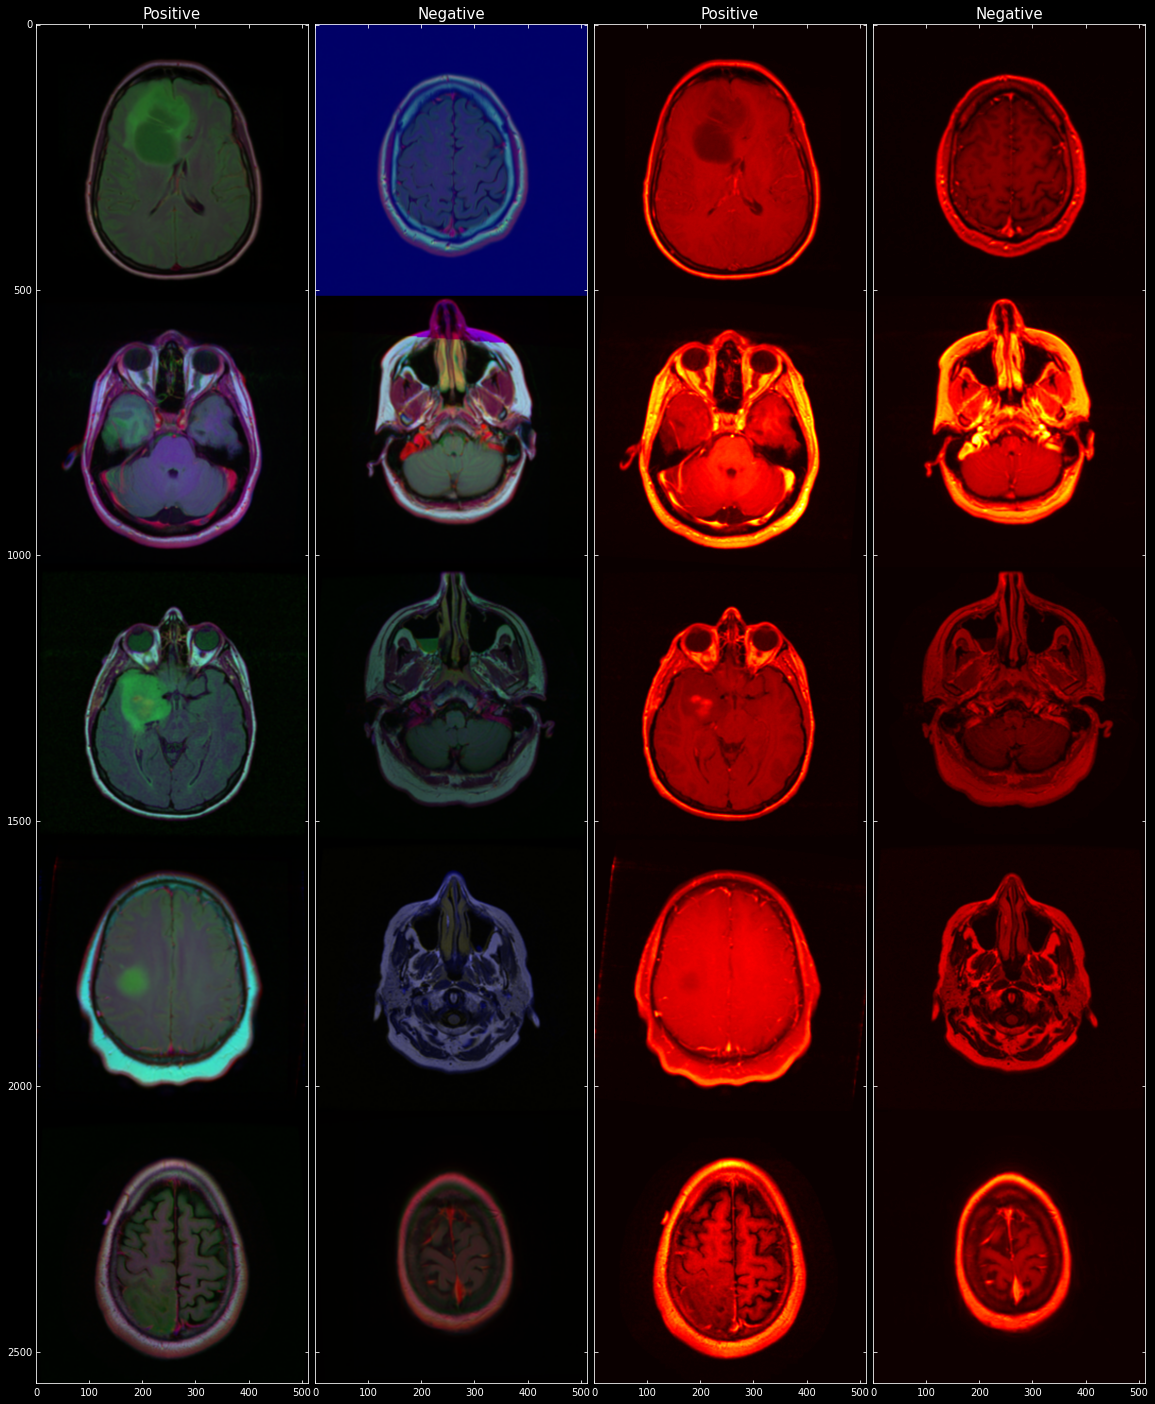

<Figure size 432x288 with 0 Axes>

In [ ]:
sample_yes_imgs=final_data[final_data["diagnosis"]==1].sample(5).image_path.values
sample_no_imgs=final_data[final_data["diagnosis"]==0].sample(5).image_path.values
sample_imgs=[]
for i,(yes,no) in enumerate(zip(sample_yes_imgs,sample_no_imgs)):
  yes=cv2.resize(cv2.imread(yes),(IMG_SIZE,IMG_SIZE))
  no=cv2.resize(cv2.imread(no),(IMG_SIZE,IMG_SIZE))
  sample_imgs.extend([yes,no])
#np.vstack - https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
sample_yes_arr=np.vstack(np.array(sample_imgs[::2]))
sample_no_arr=np.vstack(np.array(sample_imgs[1::2]))
fig = plt.figure(figsize=(25, 25))
grid=ImageGrid(fig,111,nrows_ncols=(1,4),axes_pad=0.1)
grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")
grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")
plt.show()

plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.90, fontsize=30, weight="bold")
#plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

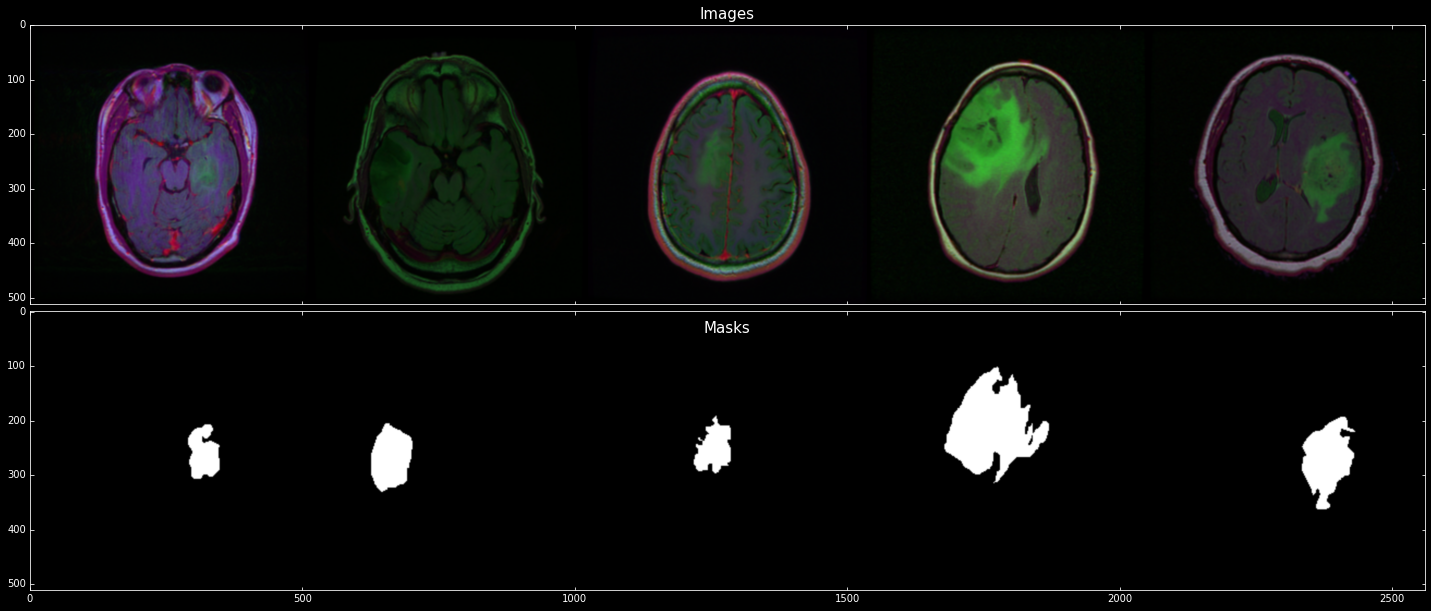

In [ ]:
sample_df = final_data[final_data["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):        
        self.df = df
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        augmented = self.transforms(image=image,mask=mask)
        image = augmented['image']
        mask = augmented['mask']   
        return image, mask

In [ ]:
PATCH_SIZE = 128 #256
strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    ToTensor(),
])

In [ ]:
transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    ToTensor(),
])

In [ ]:
train_df, val_df = train_test_split(final_data, stratify=final_data.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [ ]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

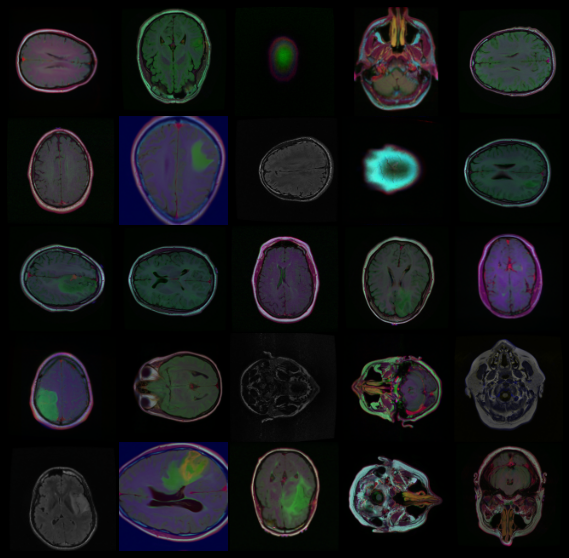

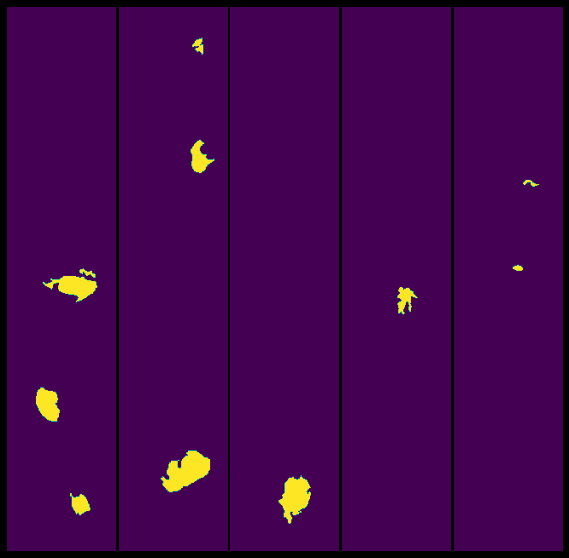

In [ ]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [ ]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):

        
        conv1 = self.conv_down1(x) 
        x = self.maxpool(conv1)     
        conv2 = self.conv_down2(x) 
        x = self.maxpool(conv2)     
        conv3 = self.conv_down3(x)  
        x = self.maxpool(conv3)     
        x = self.conv_down4(x)      
        x = self.upsample(x)                             
        x = torch.cat([x, conv3], dim=1)  
        x = self.conv_up3(x) 
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1) 
        x = self.conv_up2(x)
        x = self.upsample(x) 
        x = torch.cat([x, conv1], dim=1) 
        x = self.conv_up1(x) 
        out = self.last_conv(x)
        out = torch.sigmoid(out)
        
        return out


In [ ]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)


 torch.Size([1, 1, 256, 256])


In [ ]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out



In [ ]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [ ]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() 
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


In [ ]:
def compute_iou(model, loader, threshold=0.3):

    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)


            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss



    return valloss / i_step

In [ ]:


rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:


%%time
num_ep = 10                                                                                                  


#rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [ ]:
import pickle

In [ ]:
filename = '/content/drive/MyDrive/paidata/MODEL'

In [ ]:
infile = open(filename,'rb')
savedmodel = pickle.load(infile)
infile.close()

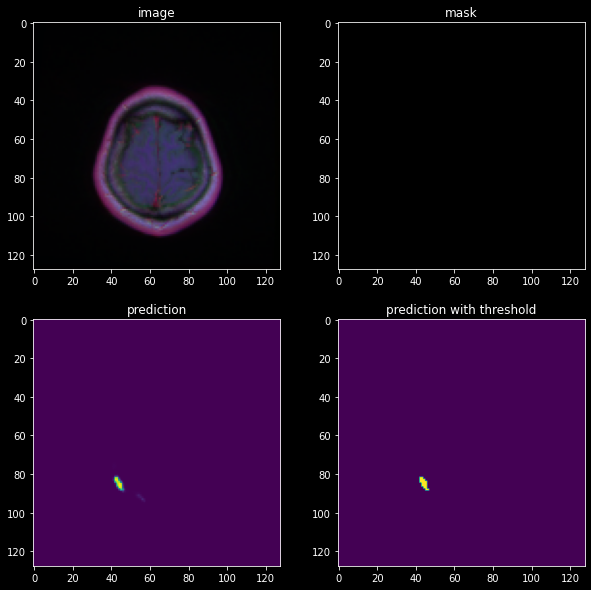

In [ ]:

test_sample = test_df[test_df["diagnosis"] == 0].sample(8).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))


mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = savedmodel(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")


fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()